In [1]:
import pandas as pd
df = pd.read_csv('~/Desktop/Datasets/2020-Jan.csv', header = 'infer', 
                parse_dates = ['event_time'], 
                 date_parser = pd.to_datetime, nrows=100000)

In [11]:
df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-01-01 00:00:00+00:00,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a
1,2020-01-01 00:00:09+00:00,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a
2,2020-01-01 00:00:19+00:00,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3
3,2020-01-01 00:00:24+00:00,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711
4,2020-01-01 00:00:25+00:00,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb


### RQ6

In [2]:
# Creating subsets

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [15]:
# Conversion rate = number of purchases / number of views

CR = purchases['product_id'].count() / views['product_id'].count()
print('The overall conversion rate is:', round(CR,3))

The overall conversion rate is: 0.087


In [21]:
df['category'].unique()

array(['nan', 'accessories', 'stationery', 'appliances', 'apparel',
       'furniture'], dtype=object)

In [16]:
# Finding categories

df['category_code'].unique()

array([nan, 'accessories.bag', 'stationery.cartrige',
       'appliances.environment.vacuum', 'apparel.glove',
       'appliances.personal.hair_cutter', 'furniture.living_room.cabinet',
       'accessories.cosmetic_bag', 'furniture.bathroom.bath',
       'appliances.environment.air_conditioner'], dtype=object)

The general categories are at the beginning of these strings (e.g. in `accessories.bag` we only need `accessories`), so we need to extract the category names

In [22]:
# Adjusting categories 

df['category'] = df.apply(lambda row: str(row.category_code).split('.')[0], axis=1)

In [23]:
df['category'].unique()

array(['nan', 'accessories', 'stationery', 'appliances', 'apparel',
       'furniture'], dtype=object)

In [25]:
# Now we create again the subsets to include the new column

views = df[df.event_type == 'view']
purchases = df[df.event_type == 'purchase']

In [26]:
# Finding number of purchases for each category

d1 = purchases.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'purchases_number'})
d1

,category,purchases_number
0,accessories,2
1,apparel,23
2,appliances,7
3,furniture,3
4,nan,4172
5,stationery,18


In [27]:
# Finding number of views for each category

d2 = views.groupby('category').event_type.count().reset_index().rename(columns =
                                                    {'event_type':'views_number'})

In [28]:
# Joining dataframes in order to have the number of purchases and views for each category

dout = d1.merge(d2, on = 'category')
dout

,category,purchases_number,views_number
0,accessories,2,142
1,apparel,23,109
2,appliances,7,558
3,furniture,3,155
4,nan,4172,47338
5,stationery,18,110


In [29]:
# Adding a third column that is a combination of the other two in order to find the c.r.

dout['conversion_rate'] = dout.apply(lambda row: 
                                     row.purchases_number / row.views_number, axis=1)

I'm assuming that the purchase rate is the number of purchases for each category. 

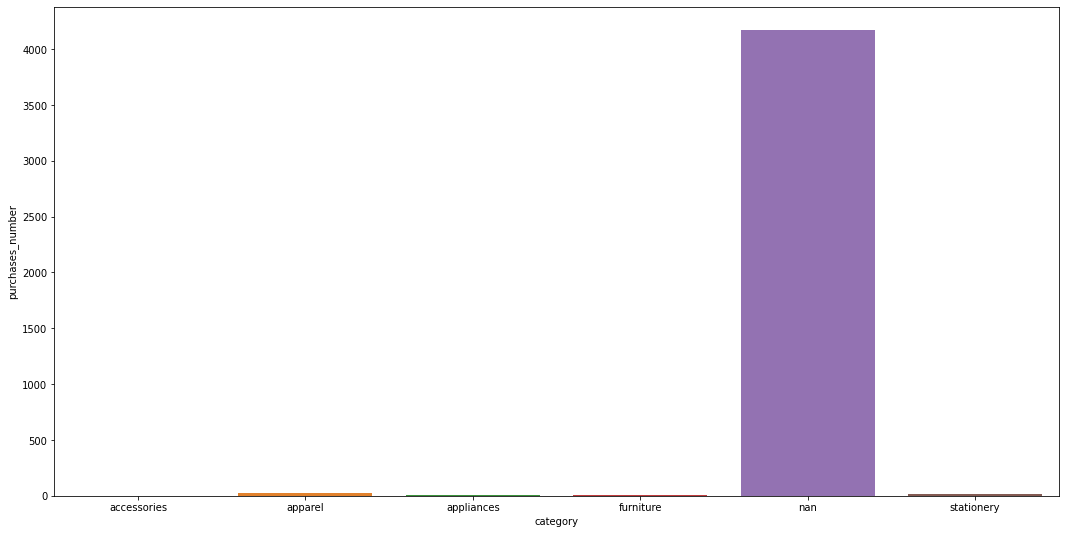

In [33]:
import seaborn as sns

fig = plt.figure(figsize=(18,9))
plot = sns.barplot(x='category', y='purchases_number', data=dout)

In [34]:
# Sorting values

dout.sort_values(by='conversion_rate', ascending = False)

,category,purchases_number,views_number,conversion_rate
1,apparel,23,109,0.211009
5,stationery,18,110,0.163636
4,nan,4172,47338,0.088132
3,furniture,3,155,0.019355
0,accessories,2,142,0.014085
2,appliances,7,558,0.012545


### RQ7

In [57]:
# Grouping customers and computing total revenue (amount of money spent) for each one 

customers = df.groupby('user_id').price.sum().to_frame('total_revenue').sort_values(
    by='total_revenue', ascending = False).reset_index()
customers

,user_id,total_revenue
0,539473388,4010.70
1,527789336,2519.19
2,559668054,2299.21
3,443690526,2197.45
4,593432191,2189.81
...,...,...
14807,595531690,0.00
14808,421017024,0.00
14809,543650069,0.00
14810,595471775,0.00


In [58]:
# Adding column with cumulative sum : cumul_sum[i] = cumul_sum[i-i] 

revenue = customers['total_revenue'].sum()
customers['cumul_sum'] = customers['total_revenue'].cumsum()
customers

,user_id,total_revenue,cumul_sum
0,539473388,4010.70,4010.70
1,527789336,2519.19,6529.89
2,559668054,2299.21,8829.10
3,443690526,2197.45,11026.55
4,593432191,2189.81,13216.36
...,...,...,...
14807,595531690,0.00,922623.94
14808,421017024,0.00,922623.94
14809,543650069,0.00,922623.94
14810,595471775,0.00,922623.94


In [59]:
# Adding column with the percentage of the cumulative sum over the store revenue 

customers['percent_cumul_sum'] = customers.apply(lambda row: 
                                     round(row.cumul_sum / revenue,3)*100, axis=1)
customers.sort_values(
    by='percent_cumul_sum')

,user_id,total_revenue,cumul_sum,percent_cumul_sum
0,539473388,4010.70,4010.70,0.4
1,527789336,2519.19,6529.89,0.7
2,559668054,2299.21,8829.10,1.0
3,443690526,2197.45,11026.55,1.2
4,593432191,2189.81,13216.36,1.4
...,...,...,...,...
14449,496505110,0.96,922386.00,100.0
14450,578915216,0.96,922386.96,100.0
14451,518184250,0.95,922387.91,100.0
14445,595674820,1.00,922382.16,100.0


In [71]:
customers.iloc[3400]

user_id              5.914266e+08
total_revenue        6.270000e+01
cumul_sum            7.453941e+05
percent_cumul_sum    8.080000e+01
Name: 3400, dtype: float64

In [79]:
print('The', round((3400/14811),2)*100,'percent of the users provides approximately the 80 percent of the store revenue.')

The 23.0 percent of the users provides approximately the 80 percent of the store revenue.


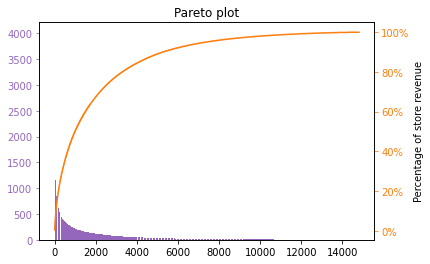

In [80]:
fig, ax = plt.subplots()
ax.bar(customers.index, customers["total_revenue"], color="C4")
ax2 = ax.twinx()
ax2.plot(customers.index, customers["percent_cumul_sum"], color="C1", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

plt.title('Pareto plot')
plt.xlabel('Users')
plt.ylabel('Percentage of store revenue')
ax.tick_params(axis="y", colors="C4")
ax2.tick_params(axis="y", colors="C1")
plt.show()